In [ ]:
import sys
import os

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error

sys.path.append(os.path.dirname(os.path.abspath('')))

from Database import PanelDataBase
from Vector import Vector


In [4]:
db = PanelDataBase()
panel_list = db.panel_list
panel = db[panel_list[2]]

Database target directory:  /home/nikolai/Yandex.Disk/diploma/Data


In [5]:
panel.initial_data

,Idx,X,Y,x_light,y_light,elevation,azimuth,adc0,adc1,adc2,adc3,adcSum,adc0_percent,adc1_percent,adc2_percent,adc3_percent,min_adc
0,1,0.028743,0.028743,-0.046406,-0.016837,2.32961,45.0000,295.453,269.781,278.4530,306.141,1149.828,25.695,23.463,24.217,26.625,23.463
1,2,-0.028743,0.028743,-0.035760,-0.016279,2.32961,135.0000,293.078,273.438,281.8590,303.406,1151.781,25.446,23.740,24.472,26.342,23.740
2,3,-0.028743,-0.028743,-0.035861,-0.004609,2.32961,225.0000,297.734,277.578,279.6720,300.969,1155.953,25.757,24.013,24.194,26.036,24.013
3,4,0.028743,-0.028743,-0.046992,-0.006082,2.32961,315.0000,299.734,273.484,276.1410,304.094,1153.453,25.986,23.710,23.940,26.364,23.710
4,5,0.086226,0.028742,-0.057070,-0.016395,5.21485,18.4349,297.422,265.953,274.1250,308.031,1145.531,25.964,23.217,23.930,26.890,23.217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,712,0.776038,-0.373648,-0.215916,0.072638,59.46350,334.2900,171.469,113.484,94.8125,151.547,531.312,32.273,21.359,17.845,28.523,17.845
712,713,-0.776038,0.373648,0.128413,-0.095152,59.46350,154.2900,106.969,138.719,167.6720,129.688,543.048,19.698,25.545,30.876,23.881,19.698
713,714,-0.776038,-0.373648,0.128371,0.078705,59.46350,205.7100,129.344,163.188,142.8120,107.031,542.375,23.848,30.088,26.331,19.734,19.734
714,715,-0.373648,-0.776038,0.039513,0.164137,59.46350,244.2900,152.000,161.953,118.3910,107.031,539.375,28.181,30.026,21.950,19.844,19.844


In [6]:
features = panel.initial_data.loc[:, ['x_light', 'y_light']].copy()
test_samples = panel.test_data.loc[:, ['x_light', 'y_light']].copy()
test_real_X = panel.test_data.loc[:, 'X'].copy()
test_real_Y = panel.test_data.loc[:, 'Y'].copy()
extended_features = panel.initial_data.loc[:, ['x_light', 'y_light', 'adc0', 'adc1', 'adc2', 'adc3']].copy()

In [7]:
X_output = panel.initial_data['X'].copy()
Y_output = panel.initial_data['Y'].copy()

In [8]:
regressor_params = {
    "objective": "reg:squarederror",  # Use squared error loss for regression
    "learning_rate": 0.1,  # Small learning rate for better generalization
    "max_depth": 3,  # Limits tree depth
    "n_estimators": 1000,  # Number of boosting rounds
    "subsample": 0.7,  # Prevents overfitting by using 80% of data per tree
}

x_regressor = xgb.XGBRegressor(**regressor_params)
y_regressor = xgb.XGBRegressor(**regressor_params)

In [9]:
x_regressor.fit(features, X_output)
y_regressor.fit(features, Y_output)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [10]:
X_pred = x_regressor.predict(test_samples)
Y_pred = y_regressor.predict(test_samples)
X_train_pred = x_regressor.predict(features)
Y_train_pred = y_regressor.predict(features)
vectors = [Vector(i,j) for i, j in zip(X_pred, Y_pred)]
real_vectors = [Vector(i,j) for i,j in zip(test_real_X, test_real_Y)]
angles = np.array([vec.toSpherical() for vec in vectors])
el_pred, az_pred = angles[:, 0], angles[:, 1]
errors = [Vector.angle_between_vectors(v1, v2) for v1, v2 in zip(vectors, real_vectors)]

In [11]:
results = pd.DataFrame({"X": test_real_X, 
                        "X_pred": X_pred, 
                        "Y": test_real_Y, 
                        "Y_pred": Y_pred,
                        "error": errors})

In [12]:
results['error'].mean(), results['error'].std()

(np.float64(1.5564651046961016), np.float64(0.7578391904532931))

In [13]:
x_regressor.save_model("gbdt_x.json")
y_regressor.save_model("gbdt_y.json")

In [14]:
test_error = mean_squared_error(X_pred, test_real_X) + mean_squared_error(Y_pred, test_real_Y)
train_error = mean_squared_error(X_train_pred, X_output) + mean_squared_error(Y_train_pred, Y_output)
print(f"Test error: {test_error}\t train error: {train_error}")

Test error: 0.0007464178782431674	 train error: 5.692758641818386e-06


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

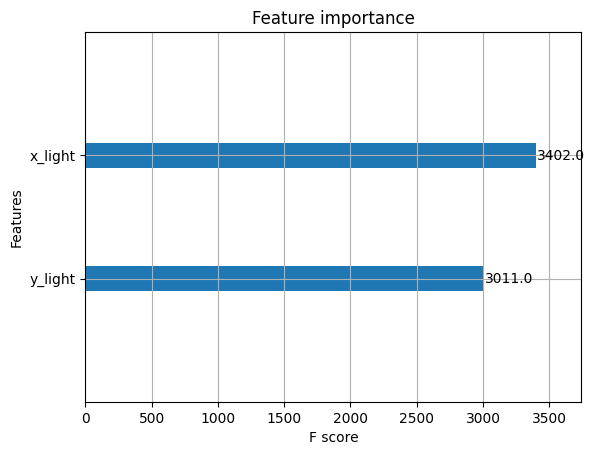

In [15]:
xgb.plot_importance(x_regressor)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

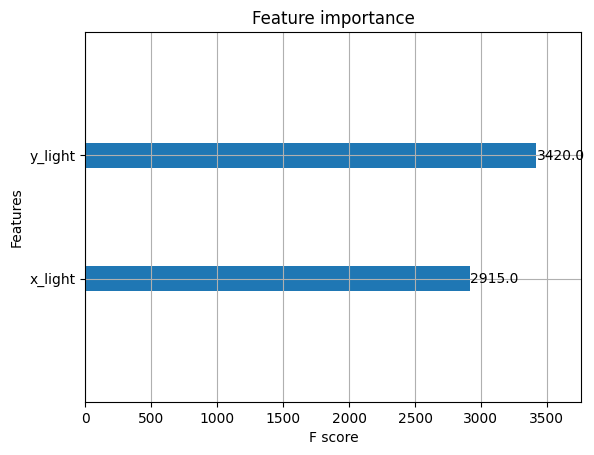

In [16]:
xgb.plot_importance(y_regressor)

In [19]:
X_pred.shape

(366,)